# Classification de documents

In [26]:
# definir les labels des clusters
import numpy as np
import matplotlib.pyplot as plt

# clusters et TF-IDF déjà calculés
# X_tfidf, km_model, clusters, vectorizer

N_CLUSTERS = km_model.n_clusters
terms = vectorizer.get_feature_names_out()
centers = km_model.cluster_centers_

# Trouver les mots les plus discriminants de chaque cluster
def discriminant_words(centers, terms, top_n=10):
    cluster_labels = {}
    for i in range(centers.shape[0]):
        top_idx = centers[i].argsort()[-top_n:][::-1]
        top_words = [terms[j] for j in top_idx]
        cluster_labels[i] = top_words
    return cluster_labels

cluster_keywords = discriminant_words(centers, terms, top_n=15)

# Affichage pour inspection humaine
for cluster_id, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_id} : {', '.join(keywords)}")


Cluster 0 : ministr, président, gouvern, loi, économ, enseign, comit, communal, match, juin, administr, défens, équip, bat, traval
Cluster 1 : concert, aff, magazin, scolair, symphon, feuilleton, actual, luxembourg, chaîn, jazz, sant, chain, concerto, disqu, mozart
Cluster 2 : ena, enf, admis, adm, tech, techn, scop, theatr, relâch, mol, path, technicolor, rio, coul, cinémascop
Cluster 3 : écrivain, poet, edit, poes, ouvrag, romanci, littérair, lecteur, rec, littératur, initial, héros, poem, volum, édit
Cluster 4 : concert, theatr, ena, abon, disqu, jeux, feuilleton, magazin, symphon, jazz, enf, admis, mannering, chain, bellamy
Cluster 5 : ballet, hest, camp, exposit, neig, bord, vedet, russ, acteur, anb, écran, rob, bois, avril, chanson


In [28]:
# Dictionnaire de correspondance cluster → label
cluster_to_label = {
    0: "Politique",
    1: "Musique_Culture",
    2: "Education_Tech_Arts",
    3: "Littérature",
    4: "Spectacle",
    5: "Arts_Visuels_Danse"
}

# Appliquer le mapping
y_label = np.array([cluster_to_label[c] for c in clusters])


## Code de classification supervisée, en utilisant TF-IDF + clusters one-hot comme features

Shape features combinées : (320, 16390)
                     precision    recall  f1-score   support

 Arts_Visuels_Danse       1.00      1.00      1.00        15
Education_Tech_Arts       1.00      1.00      1.00        14
        Littérature       1.00      1.00      1.00        13
    Musique_Culture       1.00      1.00      1.00         6
          Politique       1.00      1.00      1.00        14
          Spectacle       1.00      1.00      1.00         2

           accuracy                           1.00        64
          macro avg       1.00      1.00      1.00        64
       weighted avg       1.00      1.00      1.00        64



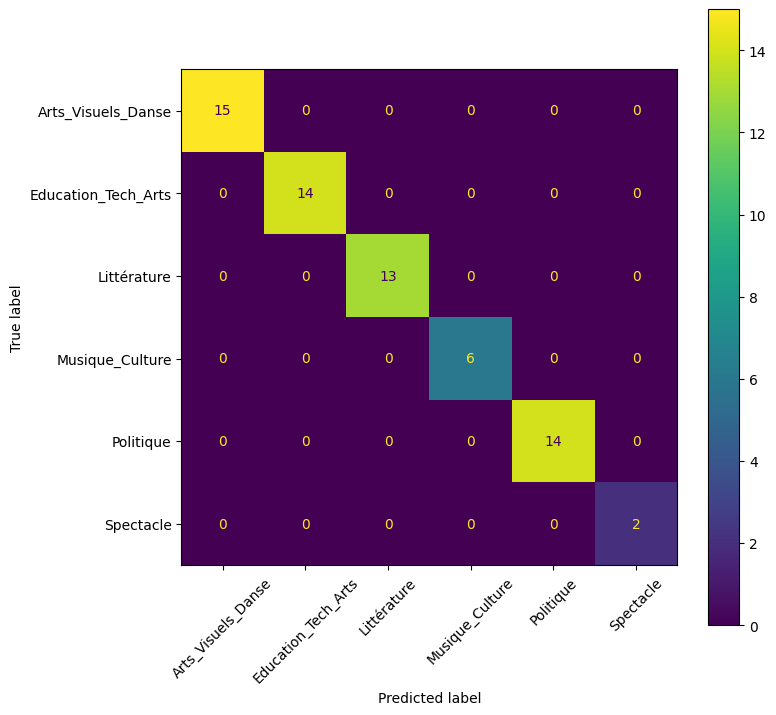

In [29]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# One-Hot encoder pour les clusters
encoder = OneHotEncoder(sparse_output=False)
clusters_onehot = encoder.fit_transform(clusters.reshape(-1,1))

# Combiner TF-IDF + clusters
X_features = hstack([X_tfidf, csr_matrix(clusters_onehot)])
print("Shape features combinées :", X_features.shape)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=42)

# Modèle Naive Bayes
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Rapport
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_label))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_label))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45)
plt.show()


### cross-validation k-fold pour tester sur plusieurs splits

In [30]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X_features, y_label, cv=5, scoring='f1_macro')
print("F1_macro CV:", scores)
print("Moyenne:", scores.mean())


F1_macro CV: [1. 1. 1. 1. 1.]
Moyenne: 1.0
